### \\\ Currently used ///

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
# use multiple GPUs
gpu = 0
multi_gpus = None#[0, 1, 2]
b = 12
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
train_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
val_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
holdout_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')

In [9]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [13]:
# dataset overview
y = np.concatenate([np.array(y_train), np.array(y_val), np.array(y_holdout)])
print("# of patients {}, # of healthy controls {}".format(np.sum(y), len(y)-np.sum(y)))

# of patients 475, # of healthy controls 494


In [10]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        #if np.isnan(X).any() == True:
        #    print("removed nan")
        #    X[np.isnan(X)] = 0.
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
            
        sample = {"image" : image,
                 "label" : label}
                 #"idx":idx}
        return sample

In [11]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [12]:
if zero_one_normalize:
    intensity = IntensityRescale()
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

In [13]:
sample = adni_data_train[400]
img = sample["image"]

In [14]:
img.shape

torch.Size([1, 96, 114, 96])

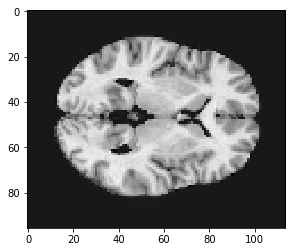

In [15]:
plt.imshow(img[0][:,:,40], cmap='gray')

# Define the classifier

In [16]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_5 = nn.Conv3d(64, 36, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        
        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            #nn.Dropout(0.6),
            nn.Linear(1296, 80),
            #nn.Dropout(0.6),
            nn.Linear(80, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if print_size:
            print(h.shape)
        
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [17]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [18]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 499845


# Training

In [19]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        
        #sched = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=12)
        #sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=5)

        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, shuffle=True
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [20]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [21]:
r = 0

In [22]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),
callbacks = [EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

Starting trial 0
torch.Size([1, 96, 114, 96])
59


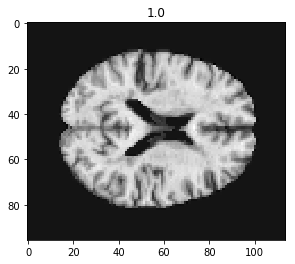

[0,    20] loss: 0.69892
[0,    40] loss: 0.68901
Time elapsed: 0h:0m:45s
train accuracy_score: 51.65 %
train balanced_accuracy: 50.95 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.678669
[1,    20] loss: 0.70093
[1,    40] loss: 0.69530
Time elapsed: 0h:1m:5s
train accuracy_score: 47.63 %
train balanced_accuracy: 47.94 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.702283
[2,    20] loss: 0.69630
[2,    40] loss: 0.69638
Time elapsed: 0h:1m:28s
train accuracy_score: 48.49 %
train balanced_accuracy: 47.78 %
val accuracy_score: 43.00 %
val balanced_accuracy: 52.50 %
Val loss: 0.693104
[3,    20] loss: 0.69399
[3,    40] loss: 0.69513
Time elapsed: 0h:1m:50s
train accuracy_score: 50.50 %
train balanced_accuracy: 49.78 %
val accuracy_score: 61.00 %
val balanced_accuracy: 51.25 %
Val loss: 0.688944
[4,    20] loss: 0.69475
[4,    40] loss: 0.69758
Time elapsed: 0h:2m:11s
train accuracy_score: 51.51 %
train balanced_accuracy: 51.60 %
val 

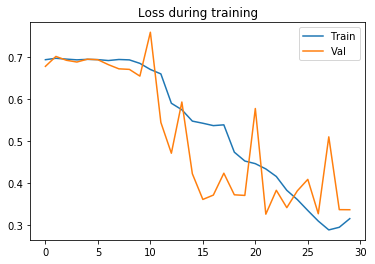

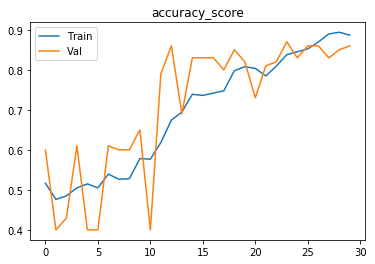

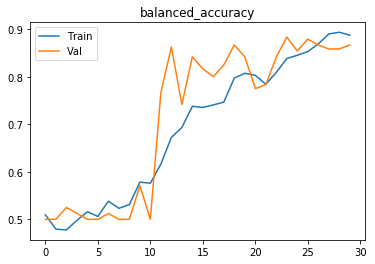

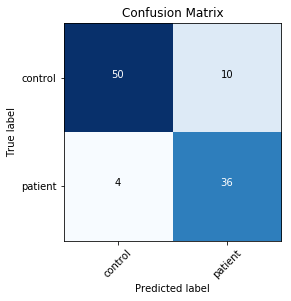

Starting trial 1
torch.Size([1, 96, 114, 96])
59


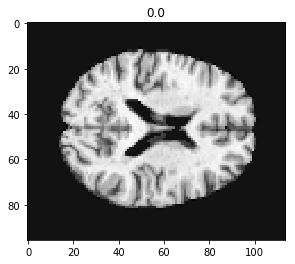

[0,    20] loss: 0.69756
[0,    40] loss: 0.69849
Time elapsed: 0h:0m:18s
train accuracy_score: 47.92 %
train balanced_accuracy: 47.57 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.703270
[1,    20] loss: 0.69509
[1,    40] loss: 0.69262
Time elapsed: 0h:0m:39s
train accuracy_score: 49.78 %
train balanced_accuracy: 49.47 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.689366
[2,    20] loss: 0.69464
[2,    40] loss: 0.69538
Time elapsed: 0h:0m:59s
train accuracy_score: 50.50 %
train balanced_accuracy: 50.68 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.722274
[3,    20] loss: 0.70070
[3,    40] loss: 0.69517
Time elapsed: 0h:1m:20s
train accuracy_score: 48.49 %
train balanced_accuracy: 47.62 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.688261
[4,    20] loss: 0.69366
[4,    40] loss: 0.69582
Time elapsed: 0h:1m:40s
train accuracy_score: 50.50 %
train balanced_accuracy: 50.58 %
val

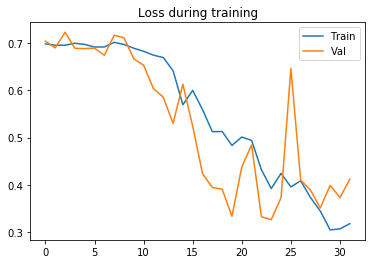

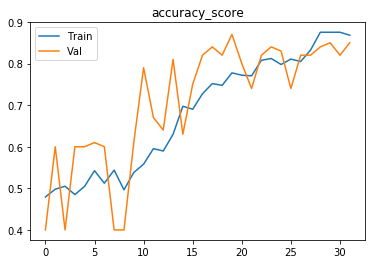

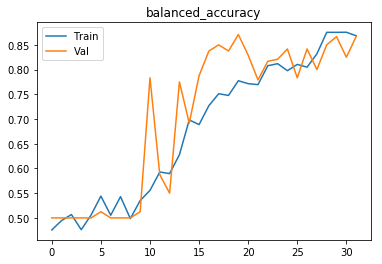

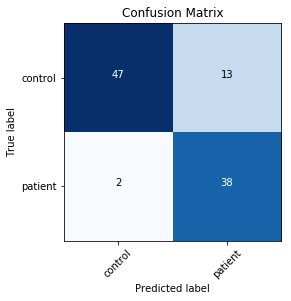

Starting trial 2
torch.Size([1, 96, 114, 96])
59


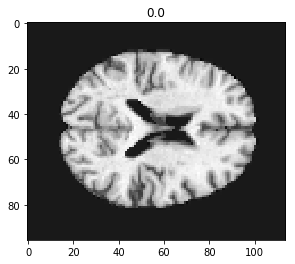

[0,    20] loss: 0.69590
[0,    40] loss: 0.69726
Time elapsed: 0h:0m:18s
train accuracy_score: 48.49 %
train balanced_accuracy: 47.56 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.686918
[1,    20] loss: 0.69394
[1,    40] loss: 0.70155
Time elapsed: 0h:0m:39s
train accuracy_score: 50.79 %
train balanced_accuracy: 50.40 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.695043
[2,    20] loss: 0.69357
[2,    40] loss: 0.69266
Time elapsed: 0h:0m:59s
train accuracy_score: 51.36 %
train balanced_accuracy: 51.79 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.693140
[3,    20] loss: 0.69425
[3,    40] loss: 0.69522
Time elapsed: 0h:1m:20s
train accuracy_score: 50.22 %
train balanced_accuracy: 49.49 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.705913
[4,    20] loss: 0.69770
[4,    40] loss: 0.69421
Time elapsed: 0h:1m:40s
train accuracy_score: 50.93 %
train balanced_accuracy: 50.81 %
val

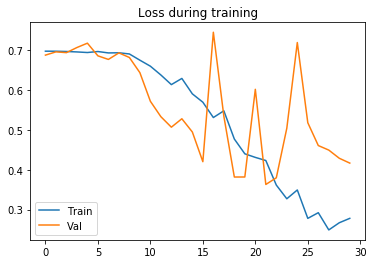

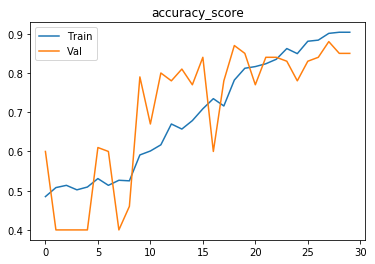

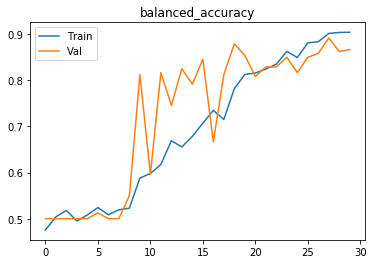

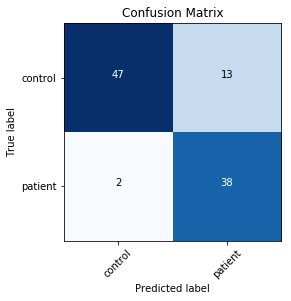

Starting trial 3
torch.Size([1, 96, 114, 96])
59


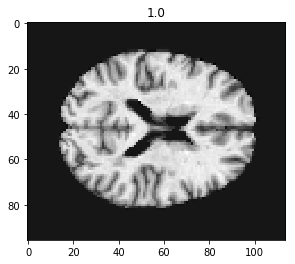

[0,    20] loss: 0.69724
[0,    40] loss: 0.69598
Time elapsed: 0h:0m:18s
train accuracy_score: 50.22 %
train balanced_accuracy: 50.27 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.706919
[1,    20] loss: 0.69395
[1,    40] loss: 0.69811
Time elapsed: 0h:0m:39s
train accuracy_score: 50.36 %
train balanced_accuracy: 49.83 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.704982
[2,    20] loss: 0.69331
[2,    40] loss: 0.69678
Time elapsed: 0h:0m:59s
train accuracy_score: 49.50 %
train balanced_accuracy: 48.44 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.697511
[3,    20] loss: 0.69774
[3,    40] loss: 0.69309
Time elapsed: 0h:1m:20s
train accuracy_score: 50.93 %
train balanced_accuracy: 50.06 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.693636
[4,    20] loss: 0.69378
[4,    40] loss: 0.69706
Time elapsed: 0h:1m:46s
train accuracy_score: 49.21 %
train balanced_accuracy: 48.04 %
val

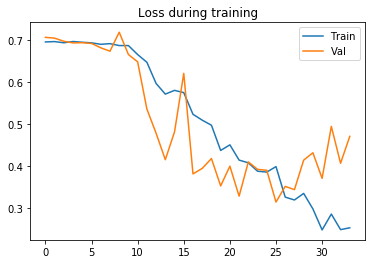

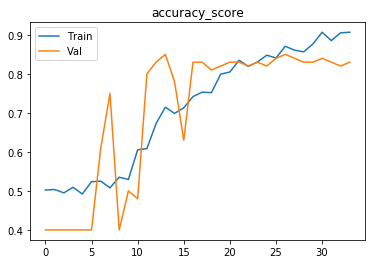

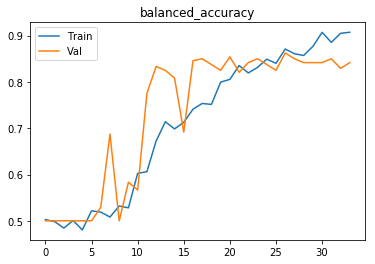

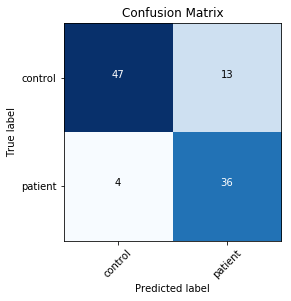

Starting trial 4
torch.Size([1, 96, 114, 96])
59


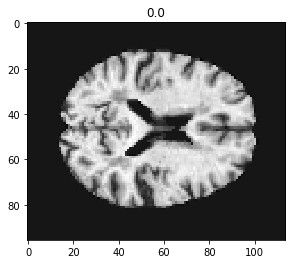

[0,    20] loss: 0.69333
[0,    40] loss: 0.70452
Time elapsed: 0h:0m:18s
train accuracy_score: 53.08 %
train balanced_accuracy: 52.90 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.679160
[1,    20] loss: 0.69417
[1,    40] loss: 0.69870
Time elapsed: 0h:0m:39s
train accuracy_score: 47.63 %
train balanced_accuracy: 47.73 %
val accuracy_score: 45.00 %
val balanced_accuracy: 53.75 %
Val loss: 0.693442
[2,    20] loss: 0.68900
[2,    40] loss: 0.69878
Time elapsed: 0h:0m:59s
train accuracy_score: 52.22 %
train balanced_accuracy: 51.94 %
val accuracy_score: 51.00 %
val balanced_accuracy: 56.25 %
Val loss: 0.692287
[3,    20] loss: 0.69574
[3,    40] loss: 0.69759
Time elapsed: 0h:1m:20s
train accuracy_score: 48.35 %
train balanced_accuracy: 48.71 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.691928
[4,    20] loss: 0.69307
[4,    40] loss: 0.69593
Time elapsed: 0h:1m:41s
train accuracy_score: 51.51 %
train balanced_accuracy: 50.90 %
val

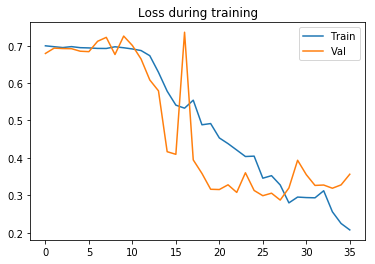

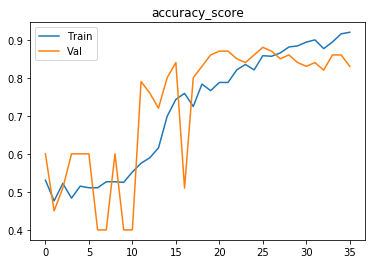

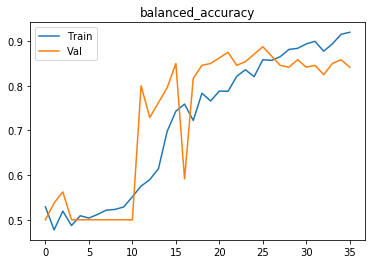

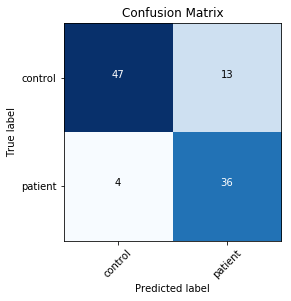

Starting trial 5
torch.Size([1, 96, 114, 96])
59


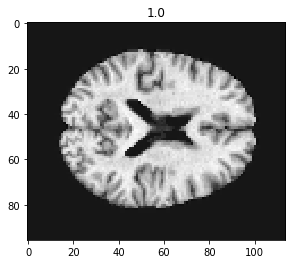

[0,    20] loss: 0.69739
[0,    40] loss: 0.69540
Time elapsed: 0h:0m:18s
train accuracy_score: 49.07 %
train balanced_accuracy: 48.50 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.725105
[1,    20] loss: 0.69974
[1,    40] loss: 0.69308
Time elapsed: 0h:0m:39s
train accuracy_score: 50.93 %
train balanced_accuracy: 49.32 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.699848
[2,    20] loss: 0.69288
[2,    40] loss: 0.69281
Time elapsed: 0h:1m:0s
train accuracy_score: 52.22 %
train balanced_accuracy: 51.21 %
val accuracy_score: 70.00 %
val balanced_accuracy: 66.25 %
Val loss: 0.688469
[3,    20] loss: 0.70625
[3,    40] loss: 0.70196
Time elapsed: 0h:1m:20s
train accuracy_score: 49.07 %
train balanced_accuracy: 49.18 %
val accuracy_score: 42.00 %
val balanced_accuracy: 51.67 %
Val loss: 0.693253
[4,    20] loss: 0.69251
[4,    40] loss: 0.69265
Time elapsed: 0h:1m:41s
train accuracy_score: 52.94 %
train balanced_accuracy: 52.66 %
val 

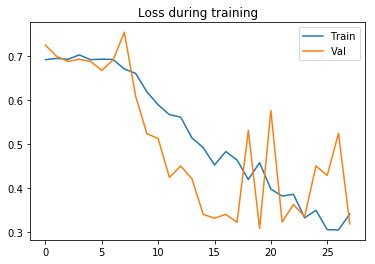

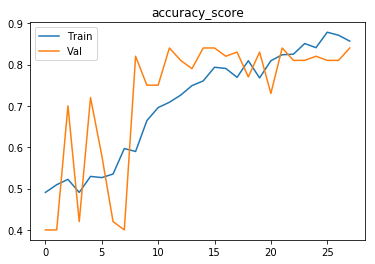

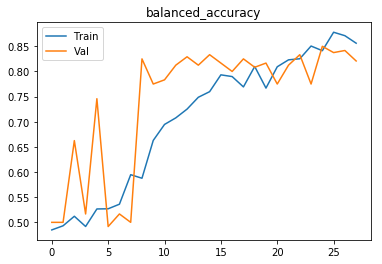

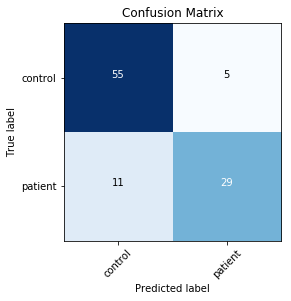

Starting trial 6
torch.Size([1, 96, 114, 96])
59


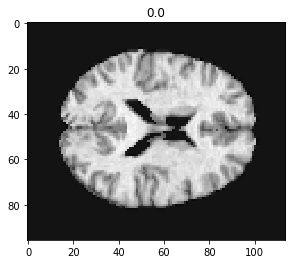

[0,    20] loss: 0.69762
[0,    40] loss: 0.69222
Time elapsed: 0h:0m:29s
train accuracy_score: 48.78 %
train balanced_accuracy: 49.04 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.702305
[1,    20] loss: 0.69541
[1,    40] loss: 0.69378
Time elapsed: 0h:0m:49s
train accuracy_score: 47.78 %
train balanced_accuracy: 47.85 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.706440
[2,    20] loss: 0.69158
[2,    40] loss: 0.69691
Time elapsed: 0h:1m:10s
train accuracy_score: 49.78 %
train balanced_accuracy: 49.63 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.708621
[3,    20] loss: 0.69910
[3,    40] loss: 0.69391
Time elapsed: 0h:1m:33s
train accuracy_score: 50.50 %
train balanced_accuracy: 49.82 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.684082
[4,    20] loss: 0.69871
[4,    40] loss: 0.69466
Time elapsed: 0h:1m:53s
train accuracy_score: 51.51 %
train balanced_accuracy: 51.26 %
val

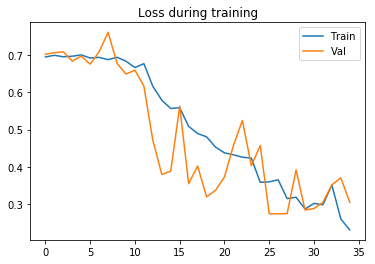

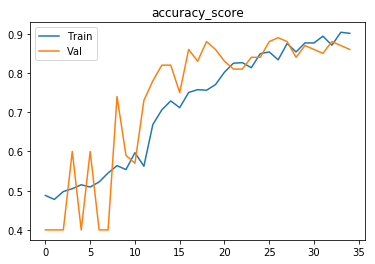

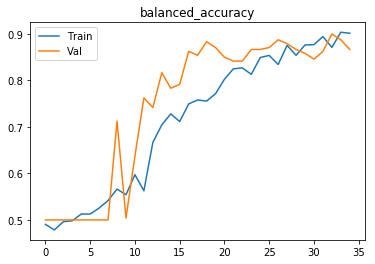

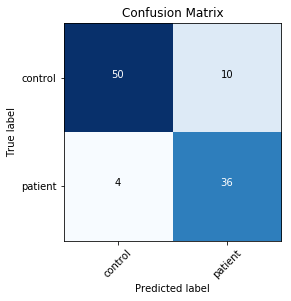

Starting trial 7
torch.Size([1, 96, 114, 96])
59


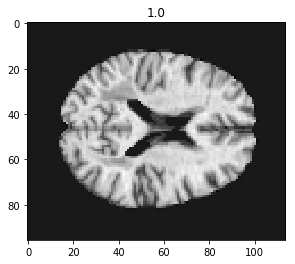

[0,    20] loss: 0.69419
[0,    40] loss: 0.69390
Time elapsed: 0h:0m:18s
train accuracy_score: 51.79 %
train balanced_accuracy: 51.68 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.710424
[1,    20] loss: 0.70691
[1,    40] loss: 0.69651
Time elapsed: 0h:0m:39s
train accuracy_score: 46.77 %
train balanced_accuracy: 46.39 %
val accuracy_score: 47.00 %
val balanced_accuracy: 53.33 %
Val loss: 0.693329
[2,    20] loss: 0.70035
[2,    40] loss: 0.69708
Time elapsed: 0h:1m:0s
train accuracy_score: 46.20 %
train balanced_accuracy: 46.41 %
val accuracy_score: 48.00 %
val balanced_accuracy: 55.83 %
Val loss: 0.692905
[3,    20] loss: 0.69760
[3,    40] loss: 0.69578
Time elapsed: 0h:1m:21s
train accuracy_score: 49.35 %
train balanced_accuracy: 49.11 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.682103
[4,    20] loss: 0.69247
[4,    40] loss: 0.69882
Time elapsed: 0h:1m:42s
train accuracy_score: 50.79 %
train balanced_accuracy: 51.09 %
val 

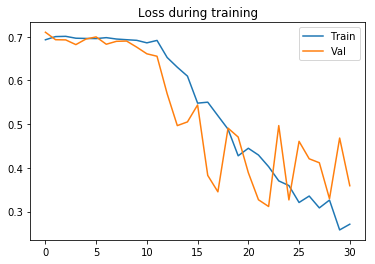

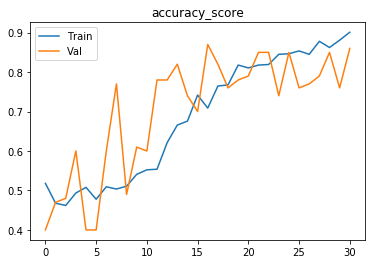

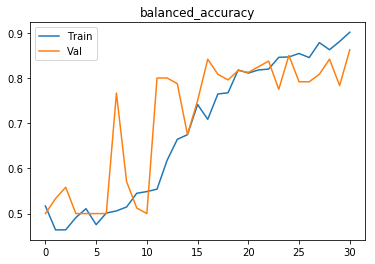

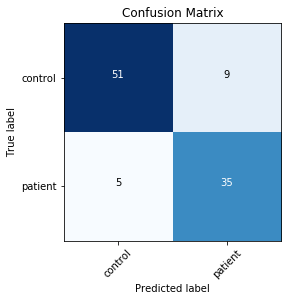

Starting trial 8
torch.Size([1, 96, 114, 96])
59


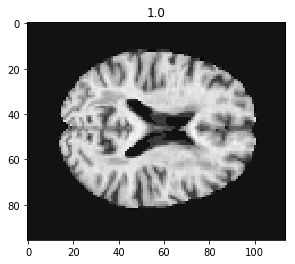

[0,    20] loss: 0.70606
[0,    40] loss: 0.69542
Time elapsed: 0h:0m:18s
train accuracy_score: 51.79 %
train balanced_accuracy: 51.33 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.718572
[1,    20] loss: 0.69258
[1,    40] loss: 0.69492
Time elapsed: 0h:0m:39s
train accuracy_score: 47.20 %
train balanced_accuracy: 47.40 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.691481
[2,    20] loss: 0.69464
[2,    40] loss: 0.69438
Time elapsed: 0h:1m:0s
train accuracy_score: 48.64 %
train balanced_accuracy: 48.38 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.682685
[3,    20] loss: 0.69513
[3,    40] loss: 0.70009
Time elapsed: 0h:1m:20s
train accuracy_score: 48.06 %
train balanced_accuracy: 47.88 %
val accuracy_score: 76.00 %
val balanced_accuracy: 73.75 %
Val loss: 0.691692
[4,    20] loss: 0.69236
[4,    40] loss: 0.69318
Time elapsed: 0h:1m:41s
train accuracy_score: 50.22 %
train balanced_accuracy: 49.08 %
val 

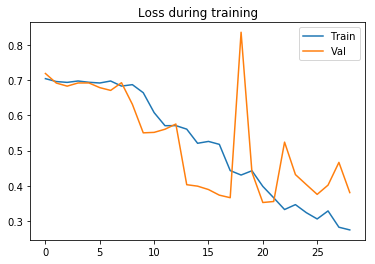

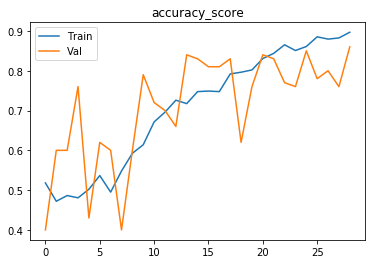

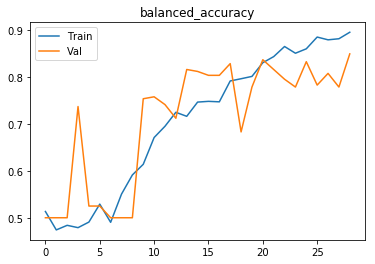

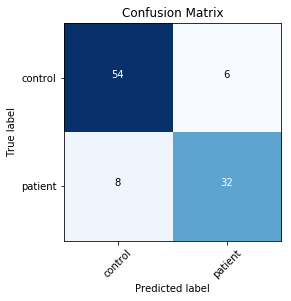

Starting trial 9
torch.Size([1, 96, 114, 96])
59


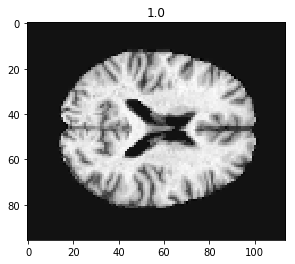

[0,    20] loss: 0.69608
[0,    40] loss: 0.69219
Time elapsed: 0h:0m:47s
train accuracy_score: 51.51 %
train balanced_accuracy: 50.70 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.708359
[1,    20] loss: 0.69647
[1,    40] loss: 0.69138
Time elapsed: 0h:1m:8s
train accuracy_score: 48.78 %
train balanced_accuracy: 47.84 %
val accuracy_score: 82.00 %
val balanced_accuracy: 81.67 %
Val loss: 0.692054
[2,    20] loss: 0.69696
[2,    40] loss: 0.69102
Time elapsed: 0h:1m:28s
train accuracy_score: 50.79 %
train balanced_accuracy: 50.85 %
val accuracy_score: 61.00 %
val balanced_accuracy: 51.25 %
Val loss: 0.686583
[3,    20] loss: 0.69400
[3,    40] loss: 0.69638
Time elapsed: 0h:1m:49s
train accuracy_score: 48.78 %
train balanced_accuracy: 48.53 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.696030
[4,    20] loss: 0.69165
[4,    40] loss: 0.70919
Time elapsed: 0h:2m:10s
train accuracy_score: 49.07 %
train balanced_accuracy: 48.99 %
val 

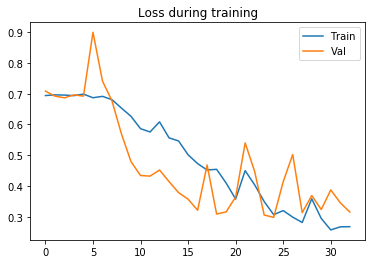

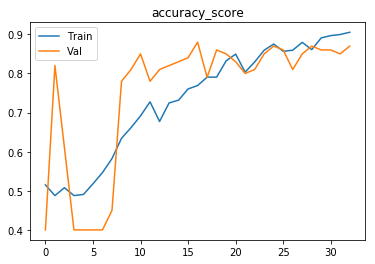

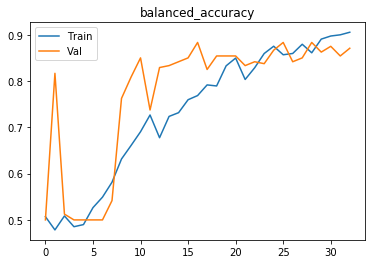

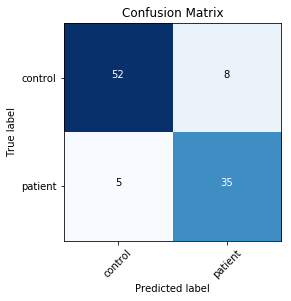

################################
################################
All accuracies: [0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8416666666666667, 0.8416666666666667, 0.8208333333333333, 0.8666666666666667, 0.8625, 0.8500000000000001, 0.8708333333333332]
0.8554166666666667
0.015484086813385041


In [23]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b,
                  augmentations=augmentations
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [24]:
# 85

In [25]:
output_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/models"

In [26]:
def save_model(model, full_path):
    print("Writing model to disk...")
    model = model.cpu()
    torch.save(model.state_dict(), full_path)

In [27]:
save_models = False

In [28]:
if save_models:
    for i, model in enumerate(models):
        model_dir = os.path.join(output_dir, "adni_baseline_499k_augmentation_copy1_84_acc_trial_{}.h5".format(i))
        save_model(model, model_dir)

In [29]:
5/0

ZeroDivisionError: division by zero

# Start inference

In [30]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [31]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.8439175257731959
Fold 1
0.8693470790378006
Fold 2
0.8375257731958763
Fold 3
0.8396563573883162
Fold 4
0.8278350515463917
Fold 5
0.8496907216494844
Fold 6
0.8351202749140894
Fold 7
0.861786941580756
Fold 8
0.8763573883161512
Fold 9
0.820274914089347
######## Final results ########
          0
0  0.843918
1  0.869347
2  0.837526
3  0.839656
4  0.827835
5  0.849691
6  0.835120
7  0.861787
8  0.876357
9  0.820275
Balanced accuracy mean 84.62 %
